# Preview - King's County Housing - No Zipcodes

- Goal of this notebook is to paste a template version of the workflow from the ADMIN_Comparing_Datasets notebook.
 
**The code will:**
- Create 4 preprocessing pipelines (one with scaling and one without)
    - `preprocessor`
        - Clone: `preprocessor_cln`
    - `preprocessor_scale`
        - Clone: `preprocessor_scale_cln`    
    
- Create 4 Versions of the X/y data.
    - **All Data/Rows:**
        - Starting Vars:
            - df,X,y, X_train, X_test,y_train,y_test
        - **Unscaled**
            - Without a  constant:
                - X_train_df, X_test_df, y_train,y_test
            - With a constant:
                - X_train_df_cnst, X_test_df_cnst, y_train (same), y_test (same)
        - **Scaled:**
            - Without a  constant:
                - X_train_df_scaled, X_test_df_scaled, y_train (same), y_test (same)
            - With a constant:
                - X_train_df_scaled_cnst, X_test_df_scaled_cnst, y_train (same), y_test (same)

    - **Cleaned/Outliers Removed**
        - Starting Vars:
            - df_clean,X_cln,y_cln, X_train_cln, X_test_cln,y_train_cln,y_test_cln
        - **Unscaled**
            - Without a  constant:
                - X_train_df_cln, X_test_df_cln, y_train,y_test
            - With a constant:
                - X_train_df_cln_cnst, X_test_df_cln_cnst, y_train_cln (same), y_test_cln (same)
        - **Scaled:**
            - Without a  constant:
                - X_train_df_cln_scaled, X_test_df_cln_scaled, y_train_cln (same), y_test_cln (same)
            - With a constant:
                - X_train_df_scaled_cln_cnst, X_test_df_cln_scaled_cnst, y_train_cln (same), y_test_cln (same)

# Code

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
## Customization Options
# pd.set_option('display.float_format',lambda x: f"{x:,.4f}")
pd.set_option("display.max_columns",100)
plt.style.use(['fivethirtyeight','seaborn-talk'])
mpl.rcParams['figure.facecolor']='white'

## additional required imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import metrics

from sklearn.base import clone

## fixing random for lesson generation
np.random.seed(321)

##import statsmodels correctly
import statsmodels.api as sm
from scipy import stats

## Customized Options
# pd.set_option('display.float_format',lambda x: f"{x:,.4f}")
# plt.style.use('seaborn-talk')

In [2]:
## Adding folder above to path
import os, sys
sys.path.append(os.path.abspath('../'))

## Load stack_functions with autoreload turned on
%load_ext autoreload
%autoreload 2
import stack_functions as sf

def show_code(function):
    import inspect 
    from IPython.display import display,Markdown, display_markdown
    code = inspect.getsource(function)
    md_txt = f"```python\n{code}\n```"
    return display(Markdown(md_txt))
    

## Preliminary Checks and Dtype Conversion

- Change:
    - `FILE`: url or filepath to load
    - `DROP_COLS`: list of columns to drop from df
    - `CONVERT_TO_STR_COLS`: numeric cols to convert to str
    - `CONVERT_TO_NUM_COLS`: str cols to convert to numeric (uses pd.to_numeric)

In [3]:
## Load in data
FILE = "https://docs.google.com/spreadsheets/d/e/2PACX-1vSEZQEzxja7Hmj5tr5nc52QqBvFQdCAGb52e1FRK1PDT2_TQrS6rY_TR9tjZjKaMbCy1m5217sVmI5q/pub?output=csv"


df = pd.read_csv(FILE)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [4]:
from pandas_profiling import ProfileReport
# ProfileReport(df)

In [5]:
## Drop unwanted columns
DROP_COLS = ['id','date','zipcode']
df = df.drop(columns=DROP_COLS)

In [6]:
## Convert all categories to strings
CONVERT_TO_STR_COLS = []
df[CONVERT_TO_STR_COLS] = df[CONVERT_TO_STR_COLS].astype(str)

CONVERT_TO_NUM_COLS = []
for col in CONVERT_TO_NUM_COLS:
    df[col] = pd.to_numeric(df[col])

In [7]:
## final info before X/y
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21613 non-null  float64
 1   bedrooms       21613 non-null  int64  
 2   bathrooms      21613 non-null  float64
 3   sqft_living    21613 non-null  int64  
 4   sqft_lot       21613 non-null  int64  
 5   floors         21613 non-null  float64
 6   waterfront     21613 non-null  int64  
 7   view           21613 non-null  int64  
 8   condition      21613 non-null  int64  
 9   grade          21613 non-null  int64  
 10  sqft_above     21613 non-null  int64  
 11  sqft_basement  21613 non-null  int64  
 12  yr_built       21613 non-null  int64  
 13  yr_renovated   21613 non-null  int64  
 14  lat            21613 non-null  float64
 15  long           21613 non-null  float64
 16  sqft_living15  21613 non-null  int64  
 17  sqft_lot15     21613 non-null  int64  
dtypes: flo

## Full Dataset Preprocessing

In [8]:
## Make x and y variables
target = 'price'
drop_cols_model = []

y = df[target].copy()
X = df.drop(columns=[target,*drop_cols_model]).copy()

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=321)
X_train.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
8306,3,2.50,2250,9235,2.0,0,0,3,8,2250,0,1985,0,47.7268,-122.105,2290,8187
18426,4,2.75,1590,6000,1.5,0,0,4,8,1590,0,1925,0,47.6401,-122.299,1590,4000
11280,4,1.75,2040,6000,1.0,0,0,5,7,1020,1020,1943,0,47.5507,-122.383,1440,6000
13891,3,1.00,1200,9800,1.0,0,0,4,7,1200,0,1971,0,47.7412,-122.109,1220,10220
6498,3,2.25,1570,8767,1.0,0,0,3,7,1180,390,1990,0,47.3568,-122.038,1570,7434


### Unscaled

In [9]:
## cat selector
cat_sel = make_column_selector(dtype_include='object')
cat_cols = cat_sel(X)

# num selectorr
num_sel = make_column_selector(dtype_include='number')
num_cols = num_sel(X)

## make pipelines & column transformer - raw numeric
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse=False))

num_pipe_raw = make_pipeline(SimpleImputer(strategy='mean'))
preprocessor = make_column_transformer((num_pipe_raw, num_sel),
                                       (cat_pipe,cat_sel), verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x289a894f0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x289a89430>)],
                  verbose_feature_names_out=False)

In [10]:
### PREP ALL X VARS
## Prepare X_train_df
X_train_df = pd.DataFrame( preprocessor.fit_transform(X_train), 
                          columns=preprocessor.get_feature_names_out(),
                         index=X_train.index)

## Prepare X_test_df
X_test_df = pd.DataFrame( preprocessor.transform(X_test),
                         columns=preprocessor.get_feature_names_out(), 
                         index=X_test.index)


## Prepare X vars with constant
X_train_df_cnst = sm.add_constant(X_train_df, prepend=False, has_constant='add')
X_test_df_cnst = sm.add_constant(X_test_df, prepend=False, has_constant='add')

In [11]:
X_train_df.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
count,16209.000000,16209.000000,16209.000000,1.620900e+04,16209.000000,16209.000000,16209.000000,16209.000000,16209.000000,16209.000000,16209.000000,16209.000000,16209.000000,16209.000000,16209.000000,16209.000000,16209.000000
mean,3.370967,2.115245,2079.601703,1.520523e+04,1.497964,0.007712,0.236597,3.410328,7.661793,1791.044481,288.557221,1971.031402,85.590721,47.560254,-122.213759,1988.143932,12864.277747
std,0.938522,0.771886,917.317141,4.212858e+04,0.541351,0.087480,0.769035,0.654447,1.178167,830.002388,440.554349,29.492575,404.410880,0.138929,0.141138,687.198385,28019.873424
min,0.000000,0.000000,290.000000,5.720000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,47.155900,-122.519000,460.000000,651.000000
25%,3.000000,1.500000,1420.000000,5.030000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,47.469800,-122.328000,1490.000000,5100.000000
50%,3.000000,2.250000,1910.000000,7.601000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,47.572800,-122.230000,1840.000000,7602.000000
75%,4.000000,2.500000,2550.000000,1.065900e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2220.000000,550.000000,1997.000000,0.000000,47.678400,-122.124000,2370.000000,10091.000000
max,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,47.777600,-121.315000,6210.000000,871200.000000


> The cell below should be updated for each dataset- only separating high cardinality OHE features (e.g. zipcode)

In [12]:
## Save list of zipcode columns and other columns
ohe_cols = [c for c in X_train_df.columns if c.startswith('zipcode')]
nonohe_cols = X_train_df.drop(columns=[*ohe_cols]).columns.tolist()

### Scaled

In [13]:
## make pipelines & column transformer - scaled
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse=False))
num_pipe_scale = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
preprocessor_scale = make_column_transformer((num_pipe_scale, num_sel),
                                       (cat_pipe,cat_sel), verbose_feature_names_out=False)
preprocessor_scale

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x289a894f0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x289a89430>)],
                  verbose_feature_names_out=False)

In [14]:
# ### PREP ALL SCALED X VARS


# Prepare X_train_scaled_df & X_test_scaled_df
X_train_scaled_df = pd.DataFrame( preprocessor_scale.fit_transform(X_train), 
                          columns=preprocessor_scale.get_feature_names_out(),
                         index=X_train.index)


X_test_scaled_df = pd.DataFrame( preprocessor_scale.transform(X_test),
                         columns=preprocessor_scale.get_feature_names_out(), 
                         index=X_test.index)


## Save vers with constant
X_train_scaled_df_cnst = sm.add_constant(X_train_scaled_df, prepend=False, has_constant='add')
X_test_scaled_df_cnst = sm.add_constant(X_test_scaled_df, prepend=False, has_constant='add')


## Save list of zipcode columns and other columns
ohe_cols = [c for c in X_train_df.columns if c.startswith('zipcode')]
nonohe_cols = X_train_df.drop(columns=[*ohe_cols]).columns.tolist()


X_test_scaled_df.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
16660,-1.460818,-0.473199,-0.032271,-0.078458,-0.919883,-0.088157,-0.307664,0.901051,0.287071,0.312003,-0.655007,-0.713130,-0.211650,0.436539,-0.037138,1.443377,-0.034415
2905,-0.395279,-0.797092,-0.424732,-0.130491,0.003761,-0.088157,-0.307664,2.429105,-0.561731,-0.121744,-0.655007,-0.577499,-0.211650,0.093189,0.550956,-0.608495,-0.107294
7700,-0.395279,0.822369,1.515769,-0.132817,2.774691,11.343368,4.893821,-0.627003,2.833479,2.022895,-0.655007,0.609277,4.733968,1.153473,-0.327642,3.116891,-0.035307
16733,0.670259,0.498477,0.491010,-0.167023,0.927404,-0.088157,-0.307664,-0.627003,0.287071,0.890333,-0.655007,0.744909,-0.211650,-2.136792,-0.696087,0.337404,-0.173142
15334,-0.395279,1.146261,1.799213,8.738346,0.003761,-0.088157,-0.307664,0.901051,1.135874,0.528877,2.749899,0.643185,-0.211650,-0.968535,1.302016,-0.070060,7.314167


In [15]:
X_train_scaled_df.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
count,1.620900e+04,1.620900e+04,1.620900e+04,1.620900e+04,1.620900e+04,1.620900e+04,1.620900e+04,1.620900e+04,1.620900e+04,1.620900e+04,1.620900e+04,1.620900e+04,1.620900e+04,1.620900e+04,1.620900e+04,1.620900e+04,1.620900e+04
mean,1.946332e-16,-2.716755e-16,-7.276827e-17,-2.191815e-17,-7.890536e-18,1.315089e-17,-6.049411e-17,-1.773179e-16,2.695933e-16,-4.471304e-17,-8.548080e-17,-2.006388e-15,9.994678e-17,-5.685438e-14,5.796124e-14,-1.258102e-16,2.674015e-17
std,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00
min,-3.591895e+00,-2.740444e+00,-1.950969e+00,-3.473574e-01,-9.198826e-01,-8.815724e-02,-3.076638e-01,-3.683110e+00,-5.654546e+00,-1.808538e+00,-6.550069e-01,-2.408525e+00,-2.116495e-01,-2.910590e+00,-2.162779e+00,-2.223799e+00,-4.358926e-01
25%,-3.952793e-01,-7.970916e-01,-7.190774e-01,-2.415353e-01,-9.198826e-01,-8.815724e-02,-3.076638e-01,-6.270026e-01,-5.617314e-01,-7.241702e-01,-6.550069e-01,-6.792225e-01,-2.116495e-01,-6.510979e-01,-8.094541e-01,-7.249134e-01,-2.771075e-01
50%,-3.952793e-01,1.745848e-01,-1.848945e-01,-1.805060e-01,3.760903e-03,-8.815724e-02,-3.076638e-01,-6.270026e-01,-5.617314e-01,-2.783746e-01,-6.550069e-01,1.345668e-01,-2.116495e-01,9.030926e-02,-1.150780e-01,-2.155833e-01,-1.878110e-01
75%,6.702591e-01,4.984770e-01,5.128137e-01,-1.079164e-01,9.274044e-01,-8.815724e-02,-3.076638e-01,9.010510e-01,2.870711e-01,5.168283e-01,5.934588e-01,8.805402e-01,-2.116495e-01,8.504316e-01,6.359818e-01,5.556879e-01,-9.897844e-02
max,3.157087e+01,7.624104e+00,1.249377e+01,3.883834e+01,3.698335e+00,1.134337e+01,4.893821e+00,2.429105e+00,4.531084e+00,9.179721e+00,1.028609e+01,1.490882e+00,4.771061e+00,1.564486e+00,6.368127e+00,6.143766e+00,3.063405e+01


## Cleaned Dataset Preprocessing

### Remove Outliers

In [16]:
show_code(sf.remove_outliers)

```python
def remove_outliers(df_,method='iqr', subset=None, verbose=2):
    """Returns a copy of the input df with outleirs removed from all
    columns using the selected method (either 'iqr' or 'z'/'zscore')
    
    Arguments:
        df_ (Frame): Dataframe to copy and remove outleirs from
        method (str): Method of outlier removal. Options are 'iqr' or 'z' (default is 'iqr')
        subset (list or None): List of column names to remove outliers from. If None, uses all numeric columns.
        verbose (bool, int): If verbose==1, print only overall summary. If verbose==2, print detailed summary"""
    import pandas as pd
    ## Make a cope of input dataframe  
    df = df_.copy()
    
    ## Set verbose_func for calls to outleir funcs
    if verbose==2:
        verbose_func = True
    else:
        verbose_func=False
        
    ## Set outlier removal function and name
    if method.lower()=='iqr':
        find_outlier_func = find_outliers_IQR
        method_name = "IQR rule"
    elif 'z' in method.lower():
        find_outlier_func = find_outliers_Z
        method_name = 'Z_score rule'
    else:
        raise Exception('[!] Method must be either "iqr" or "z".')
        
    ## Set list of cols to remove outliers from
    if subset is None:
        col_list = df.select_dtypes('number').columns
    elif isinstance(subset,str):
        col_list = [subset]
    elif isinstance(susbet, list):
        col_list = subset
    else:
        raise Exception("[!] subset must be None, a single string, or a list of strings.")

    

    
    ## Empty dict for both types of outliers
    outliers = {}

    ## Use both functions to see the comparison for # of outliers
    for col in col_list:
        idx_outliers = find_outlier_func(df[col],verbose=verbose_func)
        outliers[col] = idx_outliers

    
    ## Getting final df of all outliers to get 1 final T/F index
    outliers_combined = pd.DataFrame(outliers).any(axis=1)
    
    if verbose:
        n = len(outliers_combined)
        print(f"\n[i] Overall, {outliers_combined.sum():,} rows out of {n:,}({outliers_combined.sum()/n*100:.2f}%) were removed as outliers using {method_name}.")
    
    
    # remove_outliers 
    df_clean = df[~outliers_combined].copy()
    return df_clean

```

In [17]:
df_clean_iqr = sf.remove_outliers(df,verbose=2)
df_clean_iqr

- 1,159 outliers found in price out of 21,613 rows (5.36%) using IQR.
- 546 outliers found in bedrooms out of 21,613 rows (2.53%) using IQR.
- 571 outliers found in bathrooms out of 21,613 rows (2.64%) using IQR.
- 572 outliers found in sqft_living out of 21,613 rows (2.65%) using IQR.
- 2,425 outliers found in sqft_lot out of 21,613 rows (11.22%) using IQR.
- 0 outliers found in floors out of 21,613 rows (0.00%) using IQR.
- 163 outliers found in waterfront out of 21,613 rows (0.75%) using IQR.
- 2,124 outliers found in view out of 21,613 rows (9.83%) using IQR.
- 30 outliers found in condition out of 21,613 rows (0.14%) using IQR.
- 1,911 outliers found in grade out of 21,613 rows (8.84%) using IQR.
- 611 outliers found in sqft_above out of 21,613 rows (2.83%) using IQR.
- 496 outliers found in sqft_basement out of 21,613 rows (2.29%) using IQR.
- 0 outliers found in yr_built out of 21,613 rows (0.00%) using IQR.
- 914 outliers found in yr_renovated out of 21,613 rows (4.23%) using I

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,47.5112,-122.257,1340,5650
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,47.6168,-122.045,1800,7503
6,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,47.3097,-122.327,2238,6819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,47.6993,-122.346,1530,1509
21609,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,47.5107,-122.362,1830,7200
21610,402101.0,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,47.5944,-122.299,1020,2007
21611,400000.0,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,47.5345,-122.069,1410,1287


In [18]:
df_clean_z = sf.remove_outliers(df,method='z')
df_clean_z

- 406 outliers found in price out of 21,613 rows (1.88%) using Z-scores.
- 75 outliers found in bedrooms out of 21,613 rows (0.35%) using Z-scores.
- 187 outliers found in bathrooms out of 21,613 rows (0.87%) using Z-scores.
- 248 outliers found in sqft_living out of 21,613 rows (1.15%) using Z-scores.
- 347 outliers found in sqft_lot out of 21,613 rows (1.61%) using Z-scores.
- 8 outliers found in floors out of 21,613 rows (0.04%) using Z-scores.
- 163 outliers found in waterfront out of 21,613 rows (0.75%) using Z-scores.
- 829 outliers found in view out of 21,613 rows (3.84%) using Z-scores.
- 30 outliers found in condition out of 21,613 rows (0.14%) using Z-scores.
- 136 outliers found in grade out of 21,613 rows (0.63%) using Z-scores.
- 254 outliers found in sqft_above out of 21,613 rows (1.18%) using Z-scores.
- 247 outliers found in sqft_basement out of 21,613 rows (1.14%) using Z-scores.
- 0 outliers found in yr_built out of 21,613 rows (0.00%) using Z-scores.
- 914 outliers f

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,47.5112,-122.257,1340,5650
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,47.6168,-122.045,1800,7503
6,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,47.3097,-122.327,2238,6819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,47.6993,-122.346,1530,1509
21609,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,47.5107,-122.362,1830,7200
21610,402101.0,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,47.5944,-122.299,1020,2007
21611,400000.0,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,47.5345,-122.069,1410,1287


In [19]:
## Make x and y variables
# target = 'price'
# drop_cols_model = []

y_cln = df_clean_z[target].copy()
X_cln = df_clean_z.drop(columns=[target,*drop_cols_model]).copy()

X_train_cln, X_test_cln, y_train_cln, y_test_cln = train_test_split(X_cln,y_cln, random_state=321)
X_train_cln.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
6406,3,1.75,1750,9623,1.0,0,0,3,7,1150,600,1962,0,47.3997,-122.313,1820,9623
16601,3,2.50,3180,7904,1.0,0,0,3,8,1810,1370,2006,0,47.4890,-122.181,1950,7800
16481,3,1.50,880,6600,1.0,0,0,5,6,880,0,1945,0,47.5002,-122.247,1020,6600
13797,4,2.25,2620,33578,2.0,0,0,3,7,2620,0,1977,0,47.5921,-122.013,2520,35160
9833,2,1.00,820,2723,1.0,0,0,3,7,820,0,1921,0,47.6623,-122.339,1370,3850


### Unscaled

In [20]:
## Cloning the Previous 2 Preprocessors
preprocessor_cln = clone(preprocessor)
preprocessor_cln_scale = clone(preprocessor_scale)

In [21]:
### PREP ALL X VARS
## Prepare X_train_df
X_train_df_cln = pd.DataFrame( preprocessor_cln.fit_transform(X_train_cln), 
                          columns=preprocessor_cln.get_feature_names_out(),
                         index=X_train_cln.index)

## Prepare X_test_df
X_test_df_cln = pd.DataFrame( preprocessor_cln.transform(X_test_cln),
                         columns=preprocessor_cln.get_feature_names_out(), 
                         index=X_test_cln.index)


## Prepare X vars with constant
X_train_df_cln_cnst = sm.add_constant(X_train_df_cln, prepend=False, has_constant='add')
X_test_df_cln_cnst = sm.add_constant(X_test_df_cln, prepend=False, has_constant='add')


## Save list of zipcode columns and other columns
ohe_cols = [c for c in X_train_df_cln.columns if c.startswith('zipcode')]
nonohe_cols = X_train_df_cln.drop(columns=[*ohe_cols]).columns.tolist()

X_test_df.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
16660,2.0,1.75,2050.0,11900.0,1.0,0.0,0.0,4.0,8.0,2050.0,0.0,1950.0,0.0,47.6209,-122.219,2980.0,11900.0
2905,3.0,1.50,1690.0,9708.0,1.5,0.0,0.0,5.0,7.0,1690.0,0.0,1954.0,0.0,47.5732,-122.136,1570.0,9858.0
7700,3.0,2.75,3470.0,9610.0,3.0,1.0,4.0,3.0,11.0,3470.0,0.0,1989.0,2000.0,47.7205,-122.260,4130.0,11875.0
16733,4.0,2.50,2530.0,8169.0,2.0,0.0,0.0,3.0,8.0,2530.0,0.0,1993.0,0.0,47.2634,-122.312,2220.0,8013.0
15334,3.0,3.00,3730.0,383328.0,1.5,0.0,0.0,4.0,9.0,2230.0,1500.0,1990.0,0.0,47.4257,-122.030,1940.0,217800.0


In [22]:
X_train_df_cln.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
count,14026.000000,14026.000000,14026.000000,14026.000000,14026.000000,14026.0,14026.000000,14026.000000,14026.000000,14026.000000,14026.000000,14026.000000,14026.0,14026.000000,14026.000000,14026.000000,14026.000000
mean,3.322829,2.038001,1951.864894,9817.669614,1.481998,0.0,0.089405,3.422715,7.535078,1697.819549,254.045344,1971.727292,0.0,47.560516,-122.220398,1913.074433,9029.714245
std,0.848706,0.691919,740.005605,11416.579410,0.538447,0.0,0.395508,0.648856,1.028411,711.184980,387.164969,28.993672,0.0,0.140097,0.128678,600.621487,8785.328471
min,1.000000,0.500000,370.000000,520.000000,1.000000,0.0,0.000000,2.000000,5.000000,370.000000,0.000000,1900.000000,0.0,47.176400,-122.502000,460.000000,660.000000
25%,3.000000,1.500000,1400.000000,5000.000000,1.000000,0.0,0.000000,3.000000,7.000000,1170.000000,0.000000,1953.000000,0.0,47.468300,-122.329000,1470.000000,5000.000000
50%,3.000000,2.000000,1840.000000,7375.000000,1.000000,0.0,0.000000,3.000000,7.000000,1509.500000,0.000000,1975.000000,0.0,47.571800,-122.235000,1800.000000,7438.500000
75%,4.000000,2.500000,2410.000000,9900.000000,2.000000,0.0,0.000000,4.000000,8.000000,2100.000000,500.000000,1997.000000,0.0,47.681100,-122.134000,2260.000000,9600.000000
max,6.000000,4.250000,4750.000000,137214.000000,3.000000,0.0,2.000000,5.000000,11.000000,4270.000000,1610.000000,2015.000000,0.0,47.777600,-121.797000,4040.000000,93393.000000


### Scaled

In [23]:
# ### PREP ALL SCALED X VARS


# Prepare X_train_scaled_df & X_test_scaled_df
X_train_scaled_df_cln = pd.DataFrame( preprocessor_cln_scale.fit_transform(X_train_cln), 
                          columns=preprocessor_cln_scale.get_feature_names_out(),
                         index=X_train_cln.index)


X_test_scaled_df_cln = pd.DataFrame( preprocessor_cln_scale.transform(X_test_cln),
                         columns=preprocessor_cln_scale.get_feature_names_out(), 
                         index=X_test_cln.index)


## Save vers with constant
X_train_scaled_df_cln_cnst = sm.add_constant(X_train_scaled_df_cln, prepend=False, has_constant='add')
X_test_scaled_df_cln_cnst = sm.add_constant(X_test_scaled_df_cln, prepend=False, has_constant='add')


## Save list of zipcode columns and other columns
ohe_cols = [c for c in X_train_scaled_df_cln.columns if c.startswith('zipcode')]
nonohe_cols = X_train_scaled_df_cln.drop(columns=[*ohe_cols]).columns.tolist()


X_train_scaled_df_cln.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
6406,-0.380392,-0.416250,-0.272798,-0.017052,-0.895194,0.0,-0.22606,-0.651501,-0.520314,-0.770319,0.893591,-0.335509,0.0,-1.147934,-0.719669,-0.154969,0.067534
16601,-0.380392,0.667731,1.659689,-0.167628,-0.895194,0.0,-0.22606,-0.651501,0.452095,0.157743,2.882478,1.182118,0.0,-0.510494,0.306185,0.061481,-0.139979
16481,-0.380392,-0.777577,-1.448507,-0.281852,-0.895194,0.0,-0.22606,2.430957,-1.492723,-1.149980,-0.656192,-0.921865,0.0,-0.430546,-0.206742,-1.486970,-0.276575
13797,0.797915,0.306404,0.902911,2.081287,0.962064,0.0,-0.22606,-0.651501,-0.520314,1.296728,-0.656192,0.181864,0.0,0.225453,1.611817,1.010532,2.974416
9833,-1.558698,-1.500230,-1.529590,-0.621458,-0.895194,0.0,-0.22606,-0.651501,-0.520314,-1.234350,-0.656192,-1.749661,0.0,0.726554,-0.921731,-0.904220,-0.589608


In [24]:
X_train_scaled_df_cln.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
count,1.402600e+04,1.402600e+04,1.402600e+04,1.402600e+04,1.402600e+04,14026.0,1.402600e+04,1.402600e+04,1.402600e+04,1.402600e+04,1.402600e+04,1.402600e+04,14026.0,1.402600e+04,1.402600e+04,1.402600e+04,1.402600e+04
mean,2.269522e-16,1.904777e-16,-1.043575e-16,-2.064353e-17,-7.193574e-17,0.0,2.127677e-17,-6.028418e-17,9.574546e-17,1.104366e-16,8.004118e-17,-3.185436e-15,0.0,2.031273e-14,-2.339431e-14,2.836902e-17,2.380972e-17
std,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,0.0,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,0.0,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00
min,-2.737005e+00,-2.222884e+00,-2.137715e+00,-8.144297e-01,-8.951943e-01,0.0,-2.260599e-01,-2.192729e+00,-2.465132e+00,-1.867119e+00,-6.561916e-01,-2.473983e+00,0.0,-2.741890e+00,-2.188505e+00,-2.419371e+00,-9.527262e-01
25%,-3.803916e-01,-7.775766e-01,-7.457843e-01,-4.220039e-01,-8.951943e-01,0.0,-2.260599e-01,-6.515005e-01,-5.203143e-01,-7.421956e-01,-6.561916e-01,-6.459327e-01,0.0,-6.582541e-01,-8.440149e-01,-7.377196e-01,-4.587032e-01
50%,-3.803916e-01,-5.492292e-02,-1.511730e-01,-2.139657e-01,-8.951943e-01,0.0,-2.260599e-01,-6.515005e-01,-5.203143e-01,-2.648063e-01,-6.561916e-01,1.128806e-01,0.0,8.054811e-02,-1.134825e-01,-1.882691e-01,-1.811282e-01
75%,7.979150e-01,6.677308e-01,6.191189e-01,7.211733e-03,9.620640e-01,0.0,-2.260599e-01,8.897284e-01,4.520945e-01,5.655277e-01,6.352936e-01,8.716940e-01,0.0,8.607518e-01,6.714512e-01,5.776316e-01,6.491574e-02
max,3.154528e+00,3.197019e+00,3.781370e+00,1.115929e+01,2.819322e+00,0.0,4.830905e+00,2.430957e+00,3.369321e+00,3.616882e+00,3.502391e+00,1.492541e+00,0.0,1.549587e+00,3.290488e+00,3.541334e+00,9.603089e+00


## Modeling - Full Dataset

### Raw Numeric - No Constant

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.901
Model:                            OLS   Adj. R-squared (uncentered):              0.901
Method:                 Least Squares   F-statistic:                              9244.
Date:                Wed, 22 Jun 2022   Prob (F-statistic):                        0.00
Time:                        21:33:01   Log-Likelihood:                     -2.2131e+05
No. Observations:               16209   AIC:                                  4.427e+05
Df Residuals:                   16193   BIC:                                  4.428e+05
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
bedrooms      -3.345e+04   2204.012    -15.178      0.000   -3.78e+04   -2.91e+04
bathrooms       4.73e+04   3812.434     12.407      0.000    3.98e+04    5.48e+04
sqft_living     104.4588      2.697     38.735      0.000      99.173     109.745
sqft_lot          0.0114      0.055      0.207      0.836      -0.097       0.120
floors         1.337e+04   4156.947      3.217      0.001    5224.853    2.15e+04
waterfront     5.962e+05   2.04e+04     29.291      0.000    5.56e+05    6.36e+05
view           5.615e+04   2512.161     22.352      0.000    5.12e+04    6.11e+04
condition      2.399e+04   2738.313      8.762      0.000    1.86e+04    2.94e+04
grade           1.11e+05   2480.790     44.763      0.000    1.06e+05    1.16e+05
sqft_above       56.8444      2.607     21.806      0.000      51.735      61.954
sqft_basement    47.6144      3.073     15.496      0.000      41.592      53.637
yr_built      -3168.3047     75.919    -41.733      0.000   -3317.115   -3019.495
yr_renovated     12.1159      4.275      2.834      0.005       3.736      20.496
lat            4.871e+05   1.17e+04     41.477      0.000    4.64e+05     5.1e+05
long           1.447e+05   4823.523     30.008      0.000    1.35e+05    1.54e+05
sqft_living15    11.7042      3.995      2.930      0.003       3.874      19.535
sqft_lot15       -0.4712      0.084     -5.630      0.000      -0.635      -0.307
==============================================================================
Omnibus:                    12891.116   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           881129.846
Skew:                           3.317   Prob(JB):                         0.00
Kurtosis:                      38.506   Cond. No.                     1.32e+17
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 2.46e-21. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

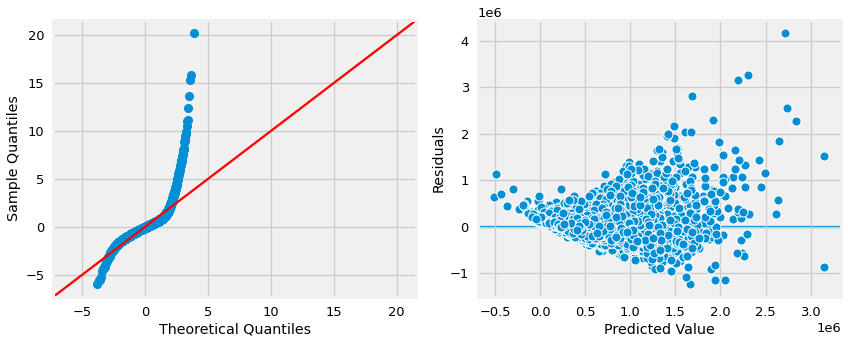

In [25]:
## instantiate an OLS model WITH the training data.
model_raw = sm.OLS(y_train, X_train_df)

## Fit the model and view the summary
result_raw = model_raw.fit()
sf.evaluate_ols(result_raw,X_train_df, y_train)

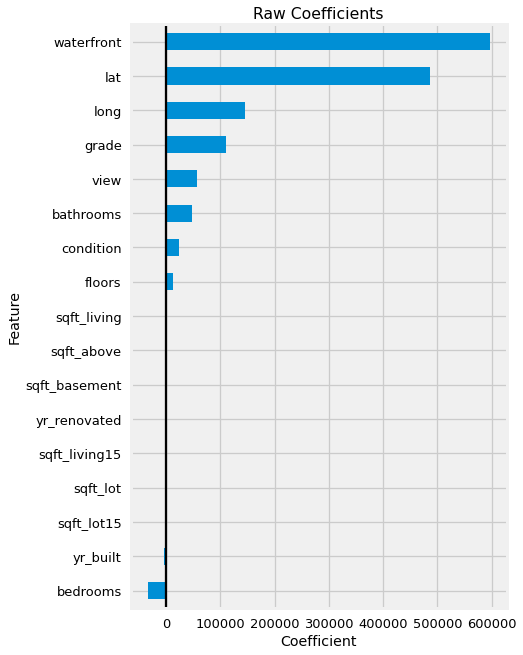

In [26]:
fig_raw = sf.plot_coeffs(result_raw, ohe_cols, include_const=True,title="Raw Coefficients")

In [27]:
fig_raw_zips =sf.plot_coeffs(result_raw, nonohe_cols, figsize=(6,12),
                           include_const=True,title="Raw Coefficients")

/Users/codingdojo/Documents/GitHub/_CURRICULUM/curriculum-model-insights/stack_functions.py:152: UserWarning: 
[!] There were no coefficients to plot.
  warnings.warn("\n[!] There were no coefficients to plot.")


### Raw Numeric - with Constant

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     2319.
Date:                Wed, 22 Jun 2022   Prob (F-statistic):               0.00
Time:                        21:33:01   Log-Likelihood:            -2.2110e+05
No. Observations:               16209   AIC:                         4.422e+05
Df Residuals:                   16192   BIC:                         4.424e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
bedrooms      -3.163e+04   2176.876    -14.528      0.000   -3.59e+04   -2.74e+04
bathrooms      4.325e+04   3767.472     11.479      0.000    3.59e+04    5.06e+04
sqft_living     104.5353      2.661     39.279      0.000      99.319     109.752
sqft_lot          0.1076      0.055      1.966      0.049       0.000       0.215
floors        -2167.1839   4169.667     -0.520      0.603   -1.03e+04    6005.824
waterfront     5.942e+05   2.01e+04     29.580      0.000    5.55e+05    6.34e+05
view           5.314e+04   2483.411     21.400      0.000    4.83e+04     5.8e+04
condition      2.993e+04   2717.399     11.015      0.000    2.46e+04    3.53e+04
grade          1.002e+05   2503.052     40.028      0.000    9.53e+04    1.05e+05
sqft_above       68.8398      2.636     26.113      0.000      63.672      74.007
sqft_basement    35.6955      3.086     11.568      0.000      29.647      41.744
yr_built      -2372.1150     84.104    -28.205      0.000   -2536.968   -2207.262
yr_renovated     20.1586      4.237      4.758      0.000      11.854      28.463
lat             5.66e+05   1.22e+04     46.422      0.000    5.42e+05     5.9e+05
long          -1.267e+05   1.39e+04     -9.137      0.000   -1.54e+05   -9.95e+04
sqft_living15    27.4896      4.015      6.847      0.000      19.620      35.359
sqft_lot15       -0.3324      0.083     -4.012      0.000      -0.495      -0.170
const         -3.846e+07   1.85e+06    -20.838      0.000   -4.21e+07   -3.48e+07
==============================================================================
Omnibus:                    12845.074   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           889274.692
Skew:                           3.292   Prob(JB):                         0.00
Kurtosis:                      38.684   Cond. No.                     1.31e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.49e-21. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

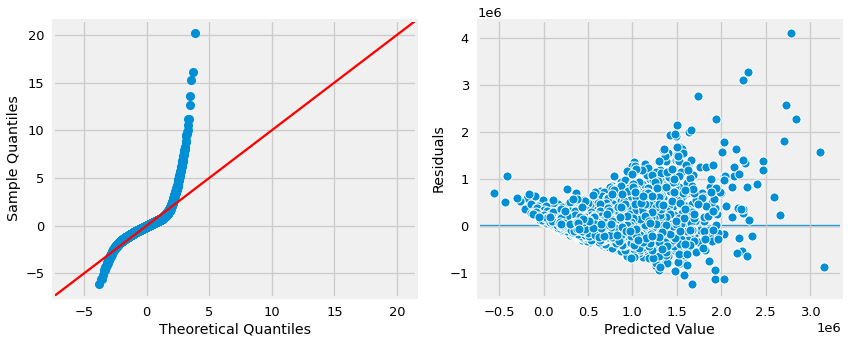

In [28]:
## instantiate an OLS model WITH the training data.
model_raw_cnst = sm.OLS(y_train, X_train_df_cnst)

## Fit the model and view the summary
result_raw_cnst = model_raw_cnst.fit()
sf.evaluate_ols(result_raw_cnst,X_train_df_cnst, y_train)

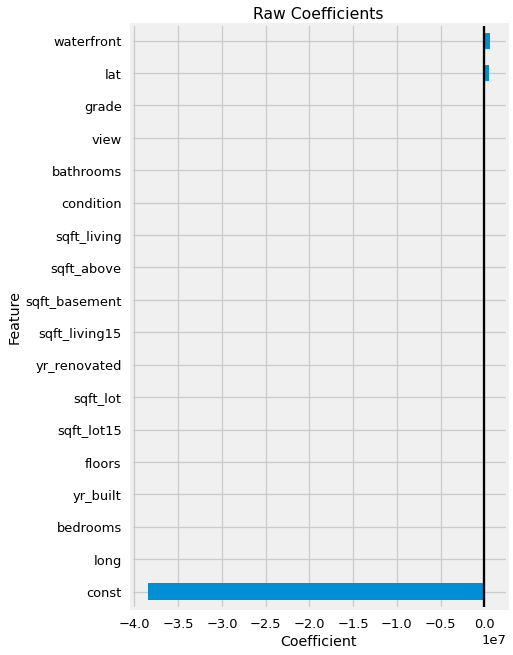

In [29]:
fig_raw =sf.plot_coeffs(result_raw_cnst, ohe_cols, include_const=True,title="Raw Coefficients")

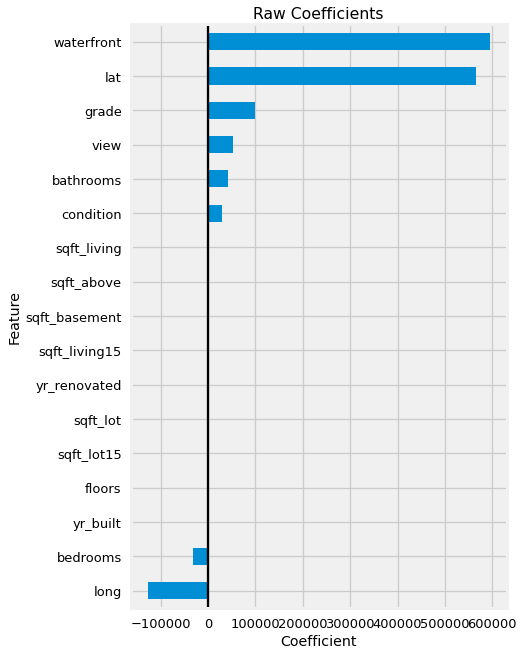

In [30]:
fig_raw =sf.plot_coeffs(result_raw_cnst, ohe_cols, include_const=False,title="Raw Coefficients")

In [31]:
fig_raw_zips =sf.plot_coeffs(result_raw_cnst, nonohe_cols, figsize=(6,12),include_const=False,title="Raw Coefficients")

/Users/codingdojo/Documents/GitHub/_CURRICULUM/curriculum-model-insights/stack_functions.py:152: UserWarning: 
[!] There were no coefficients to plot.
  warnings.warn("\n[!] There were no coefficients to plot.")


### Scaled Numeric - No Constant

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.220
Model:                            OLS   Adj. R-squared (uncentered):              0.219
Method:                 Least Squares   F-statistic:                              285.8
Date:                Wed, 22 Jun 2022   Prob (F-statistic):                        0.00
Time:                        21:33:02   Log-Likelihood:                     -2.3807e+05
No. Observations:               16209   AIC:                                  4.762e+05
Df Residuals:                   16193   BIC:                                  4.763e+05
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
bedrooms      -2.968e+04   5819.270     -5.100      0.000   -4.11e+04   -1.83e+04
bathrooms      3.338e+04   8283.112      4.030      0.000    1.71e+04    4.96e+04
sqft_living    7.801e+04   5318.666     14.667      0.000    6.76e+04    8.84e+04
sqft_lot       4534.8254   6569.904      0.690      0.490   -8342.913    1.74e+04
floors        -1173.1712   6429.407     -0.182      0.855   -1.38e+04    1.14e+04
waterfront     5.198e+04   5005.525     10.385      0.000    4.22e+04    6.18e+04
view           4.087e+04   5439.829      7.513      0.000    3.02e+04    5.15e+04
condition      1.959e+04   5065.459      3.867      0.000    9659.974    2.95e+04
grade           1.18e+05   8399.765     14.053      0.000    1.02e+05    1.35e+05
sqft_above     7.331e+04   5663.689     12.944      0.000    6.22e+04    8.44e+04
sqft_basement  2.431e+04   5162.517      4.709      0.000    1.42e+04    3.44e+04
yr_built      -6.996e+04   7065.125     -9.902      0.000   -8.38e+04   -5.61e+04
yr_renovated   8152.1146   4880.440      1.670      0.095   -1414.088    1.77e+04
lat            7.864e+04   4825.055     16.297      0.000    6.92e+04    8.81e+04
long          -1.789e+04   5575.944     -3.208      0.001   -2.88e+04   -6955.767
sqft_living15  1.889e+04   7858.216      2.404      0.016    3487.252    3.43e+04
sqft_lot15    -9314.0142   6612.972     -1.408      0.159   -2.23e+04    3648.142
==============================================================================
Omnibus:                    12845.074   Durbin-Watson:                   0.246
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           889274.692
Skew:                           3.292   Prob(JB):                         0.00
Kurtosis:                      38.684   Cond. No.                     3.06e+15
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 8.85e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

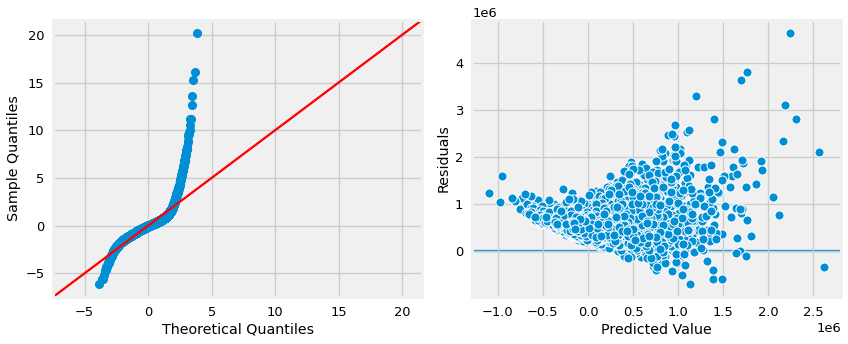

In [32]:
## instantiate an OLS model WITH the training data.
model_scaled = sm.OLS(y_train, X_train_scaled_df)

## Fit the model and view the summary
result_scaled = model_scaled.fit()
sf.evaluate_ols(result_scaled,X_train_scaled_df, y_train)

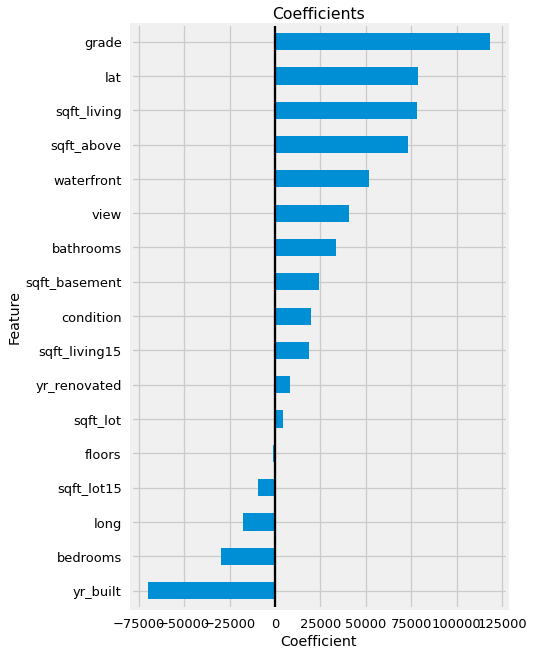

In [33]:
fig_scaled =sf.plot_coeffs(result_scaled,ohe_cols,include_const=True)

In [34]:
fig_scaled_zips =sf.plot_coeffs(result_scaled, nonohe_cols, figsize=(6,12),include_const=True,title="Raw Coefficients")

/Users/codingdojo/Documents/GitHub/_CURRICULUM/curriculum-model-insights/stack_functions.py:152: UserWarning: 
[!] There were no coefficients to plot.
  warnings.warn("\n[!] There were no coefficients to plot.")


### Scaled Numeric - with Constant

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     2319.
Date:                Wed, 22 Jun 2022   Prob (F-statistic):               0.00
Time:                        21:33:02   Log-Likelihood:            -2.2110e+05
No. Observations:               16209   AIC:                         4.422e+05
Df Residuals:                   16192   BIC:                         4.424e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
bedrooms      -2.968e+04   2042.982    -14.528      0.000   -3.37e+04   -2.57e+04
bathrooms      3.338e+04   2907.968     11.479      0.000    2.77e+04    3.91e+04
sqft_living    7.801e+04   1867.234     41.779      0.000    7.44e+04    8.17e+04
sqft_lot       4534.8254   2306.508      1.966      0.049      13.814    9055.837
floors        -1173.1712   2257.184     -0.520      0.603   -5597.501    3251.159
waterfront     5.198e+04   1757.299     29.580      0.000    4.85e+04    5.54e+04
view           4.087e+04   1909.771     21.400      0.000    3.71e+04    4.46e+04
condition      1.959e+04   1778.340     11.015      0.000    1.61e+04    2.31e+04
grade           1.18e+05   2948.921     40.028      0.000    1.12e+05    1.24e+05
sqft_above     7.331e+04   1988.362     36.871      0.000    6.94e+04    7.72e+04
sqft_basement  2.431e+04   1812.415     13.414      0.000    2.08e+04    2.79e+04
yr_built      -6.996e+04   2480.367    -28.205      0.000   -7.48e+04   -6.51e+04
yr_renovated   8152.1146   1713.385      4.758      0.000    4793.690    1.15e+04
lat            7.864e+04   1693.941     46.422      0.000    7.53e+04     8.2e+04
long          -1.789e+04   1957.557     -9.137      0.000   -2.17e+04    -1.4e+04
sqft_living15  1.889e+04   2758.798      6.847      0.000    1.35e+04    2.43e+04
sqft_lot15    -9314.0142   2321.628     -4.012      0.000   -1.39e+04   -4763.366
const          5.417e+05   1596.191    339.396      0.000    5.39e+05    5.45e+05
==============================================================================
Omnibus:                    12845.074   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           889274.692
Skew:                           3.292   Prob(JB):                         0.00
Kurtosis:                      38.684   Cond. No.                     3.42e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.09e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

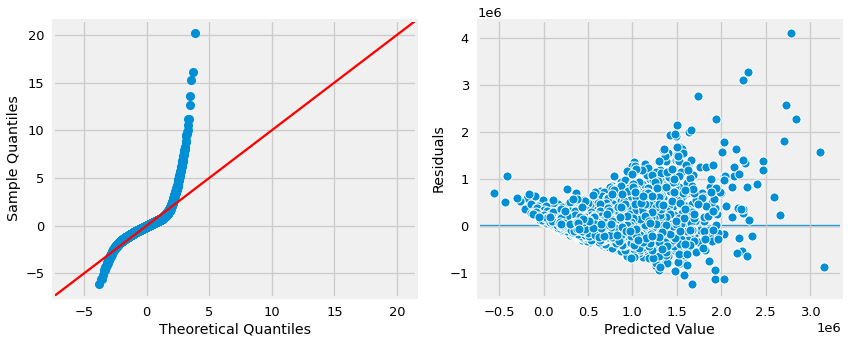

In [35]:
## instantiate an OLS model WITH the training data.
model_scaled_cnst = sm.OLS(y_train, X_train_scaled_df_cnst)

## Fit the model and view the summary
result_scaled_cnst = model_scaled_cnst.fit()
sf.evaluate_ols(result_scaled_cnst,X_train_scaled_df_cnst, y_train)

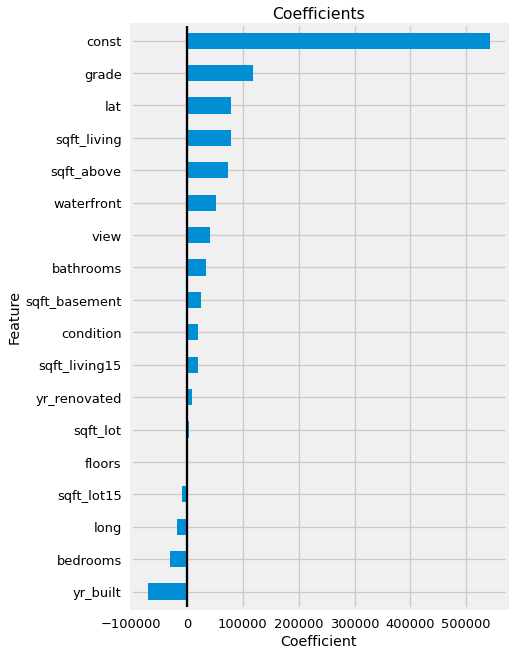

In [36]:
fig_scaled =sf.plot_coeffs(result_scaled_cnst,ohe_cols,include_const=True)

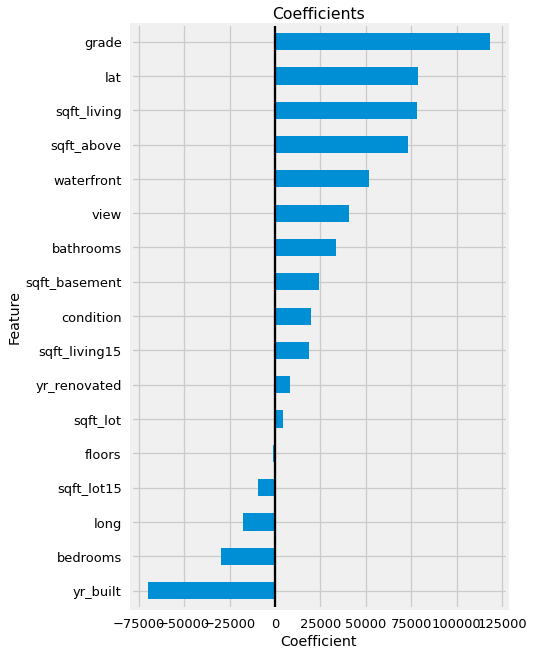

In [37]:
fig_scaled =sf.plot_coeffs(result_scaled_cnst,ohe_cols,include_const=False)

In [38]:
fig_scaled_zips =sf.plot_coeffs(result_scaled_cnst, nonohe_cols, figsize=(6,12),include_const=True,title="Raw Coefficients")

/Users/codingdojo/Documents/GitHub/_CURRICULUM/curriculum-model-insights/stack_functions.py:152: UserWarning: 
[!] There were no coefficients to plot.
  warnings.warn("\n[!] There were no coefficients to plot.")


## Modeling - No Outliers

### Raw Numeric - No Constant

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.937
Model:                            OLS   Adj. R-squared (uncentered):              0.937
Method:                 Least Squares   F-statistic:                          1.492e+04
Date:                Wed, 22 Jun 2022   Prob (F-statistic):                        0.00
Time:                        21:33:02   Log-Likelihood:                     -1.8550e+05
No. Observations:               14026   AIC:                                  3.710e+05
Df Residuals:                   14012   BIC:                                  3.711e+05
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
bedrooms      -1.339e+04   1746.142     -7.668      0.000   -1.68e+04   -9965.967
bathrooms      3.035e+04   2901.141     10.463      0.000    2.47e+04     3.6e+04
sqft_living      62.3944      2.204     28.314      0.000      58.075      66.714
sqft_lot          0.2855      0.170      1.678      0.093      -0.048       0.619
floors         3.541e+04   3054.711     11.593      0.000    2.94e+04    4.14e+04
waterfront    -3.218e-09   8.82e-11    -36.468      0.000   -3.39e-09   -3.04e-09
view           3.767e+04   2956.300     12.742      0.000    3.19e+04    4.35e+04
condition      2.675e+04   1942.034     13.772      0.000    2.29e+04    3.06e+04
grade            9.4e+04   1836.394     51.185      0.000    9.04e+04    9.76e+04
sqft_above       26.2587      2.052     12.794      0.000      22.236      30.282
sqft_basement    36.1357      2.407     15.014      0.000      31.418      40.853
yr_built      -2610.6686     55.575    -46.976      0.000   -2719.602   -2501.735
yr_renovated  -2.284e-10   3.96e-12    -57.728      0.000   -2.36e-10   -2.21e-10
lat            5.061e+05   8219.391     61.573      0.000     4.9e+05    5.22e+05
long           1.599e+05   3396.397     47.075      0.000    1.53e+05    1.67e+05
sqft_living15    35.7637      3.187     11.222      0.000      29.517      42.010
sqft_lot15       -2.0669      0.224     -9.217      0.000      -2.506      -1.627
==============================================================================
Omnibus:                     4275.535   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20254.100
Skew:                           1.409   Prob(JB):                         0.00
Kurtosis:                       8.169   Cond. No.                     1.37e+22
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 2.81e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

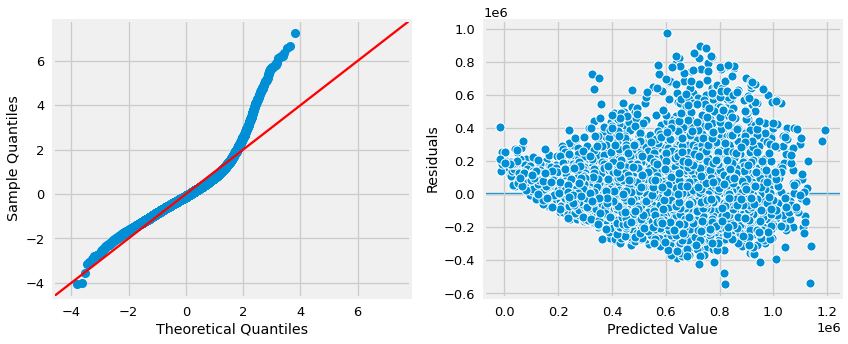

In [39]:
## instantiate an OLS model WITH the training data.
model_cln = sm.OLS(y_train_cln, X_train_df_cln)

## Fit the model and view the summary
result_cln = model_cln.fit()
sf.evaluate_ols(result_cln,X_train_df_cln, y_train_cln)

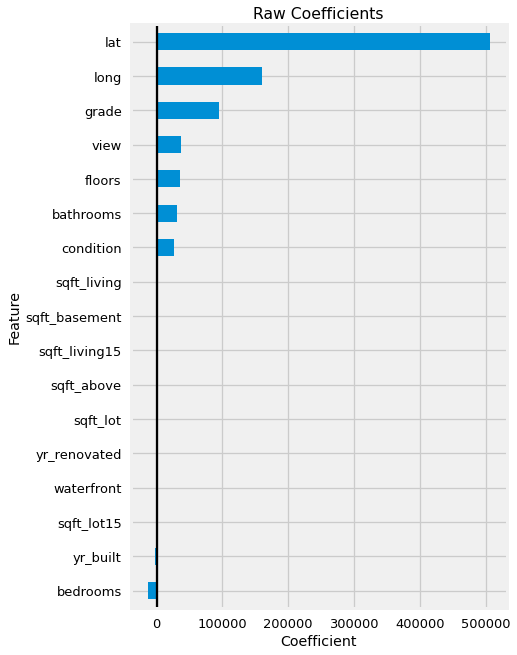

In [40]:
fig_raw =sf.plot_coeffs(result_cln, ohe_cols, include_const=True,title="Raw Coefficients")

In [41]:
fig_raw_zips =sf.plot_coeffs(result_cln, nonohe_cols, figsize=(6,12),include_const=True,title="Raw Coefficients")

/Users/codingdojo/Documents/GitHub/_CURRICULUM/curriculum-model-insights/stack_functions.py:152: UserWarning: 
[!] There were no coefficients to plot.
  warnings.warn("\n[!] There were no coefficients to plot.")


### Raw Numeric - with Constant

In [42]:
X_train_df_cln_cnst.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,const
count,14026.000000,14026.000000,14026.000000,14026.000000,14026.000000,14026.0,14026.000000,14026.000000,14026.000000,14026.000000,14026.000000,14026.000000,14026.0,14026.000000,14026.000000,14026.000000,14026.000000,14026.0
mean,3.322829,2.038001,1951.864894,9817.669614,1.481998,0.0,0.089405,3.422715,7.535078,1697.819549,254.045344,1971.727292,0.0,47.560516,-122.220398,1913.074433,9029.714245,1.0
std,0.848706,0.691919,740.005605,11416.579410,0.538447,0.0,0.395508,0.648856,1.028411,711.184980,387.164969,28.993672,0.0,0.140097,0.128678,600.621487,8785.328471,0.0
min,1.000000,0.500000,370.000000,520.000000,1.000000,0.0,0.000000,2.000000,5.000000,370.000000,0.000000,1900.000000,0.0,47.176400,-122.502000,460.000000,660.000000,1.0
25%,3.000000,1.500000,1400.000000,5000.000000,1.000000,0.0,0.000000,3.000000,7.000000,1170.000000,0.000000,1953.000000,0.0,47.468300,-122.329000,1470.000000,5000.000000,1.0
50%,3.000000,2.000000,1840.000000,7375.000000,1.000000,0.0,0.000000,3.000000,7.000000,1509.500000,0.000000,1975.000000,0.0,47.571800,-122.235000,1800.000000,7438.500000,1.0
75%,4.000000,2.500000,2410.000000,9900.000000,2.000000,0.0,0.000000,4.000000,8.000000,2100.000000,500.000000,1997.000000,0.0,47.681100,-122.134000,2260.000000,9600.000000,1.0
max,6.000000,4.250000,4750.000000,137214.000000,3.000000,0.0,2.000000,5.000000,11.000000,4270.000000,1610.000000,2015.000000,0.0,47.777600,-121.797000,4040.000000,93393.000000,1.0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     2065.
Date:                Wed, 22 Jun 2022   Prob (F-statistic):               0.00
Time:                        21:33:03   Log-Likelihood:            -1.8533e+05
No. Observations:               14026   AIC:                         3.707e+05
Df Residuals:                   14011   BIC:                         3.708e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
bedrooms      -1.221e+04   1726.613     -7.073      0.000   -1.56e+04   -8827.886
bathrooms      2.937e+04   2867.225     10.244      0.000    2.38e+04     3.5e+04
sqft_living      61.7239      2.178     28.342      0.000      57.455      65.993
sqft_lot          0.4339      0.168      2.578      0.010       0.104       0.764
floors         2.578e+04   3063.480      8.414      0.000    1.98e+04    3.18e+04
waterfront    -1.073e-06   5.92e-08    -18.119      0.000   -1.19e-06   -9.57e-07
view            3.47e+04   2925.674     11.861      0.000     2.9e+04    4.04e+04
condition      3.118e+04   1934.039     16.122      0.000    2.74e+04     3.5e+04
grade          8.672e+04   1857.060     46.699      0.000    8.31e+04    9.04e+04
sqft_above       35.0664      2.084     16.829      0.000      30.982      39.151
sqft_basement    26.6574      2.433     10.955      0.000      21.888      31.427
yr_built      -2105.2757     61.386    -34.296      0.000   -2225.601   -1984.950
yr_renovated  -1.993e-08   1.08e-09    -18.427      0.000    -2.2e-08   -1.78e-08
lat            5.496e+05   8458.128     64.977      0.000    5.33e+05    5.66e+05
long           -3.38e+04    1.1e+04     -3.063      0.002   -5.54e+04   -1.22e+04
sqft_living15    46.8301      3.206     14.608      0.000      40.546      53.114
sqft_lot15       -1.7055      0.222     -7.667      0.000      -2.142      -1.269
const         -2.672e+07   1.45e+06    -18.423      0.000   -2.96e+07   -2.39e+07
==============================================================================
Omnibus:                     4048.868   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18743.461
Skew:                           1.335   Prob(JB):                         0.00
Kurtosis:                       7.994   Cond. No.                     3.34e+21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.71e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

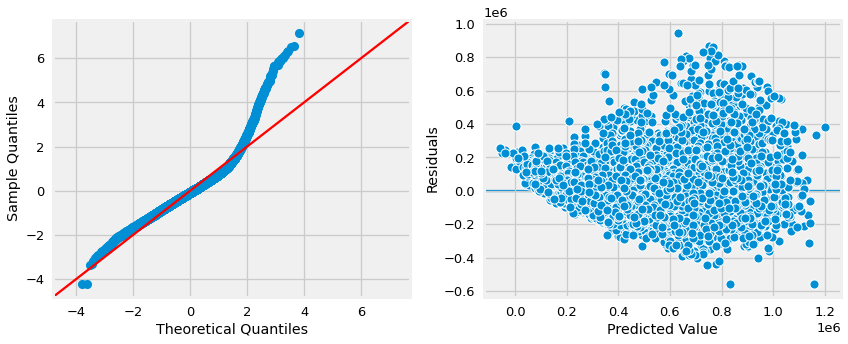

In [43]:
## instantiate an OLS model WITH the training data.
model_cln_cnst = sm.OLS(y_train_cln, X_train_df_cln_cnst)

## Fit the model and view the summary
result_cln_cnst = model_cln_cnst.fit()
sf.evaluate_ols(result_cln_cnst,X_train_df_cln_cnst, y_train_cln)

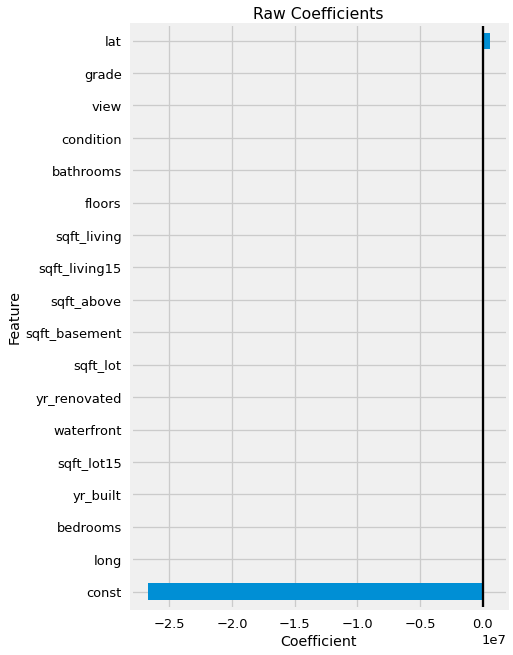

In [44]:
fig_raw =sf.plot_coeffs(result_cln_cnst, ohe_cols, include_const=True,title="Raw Coefficients")

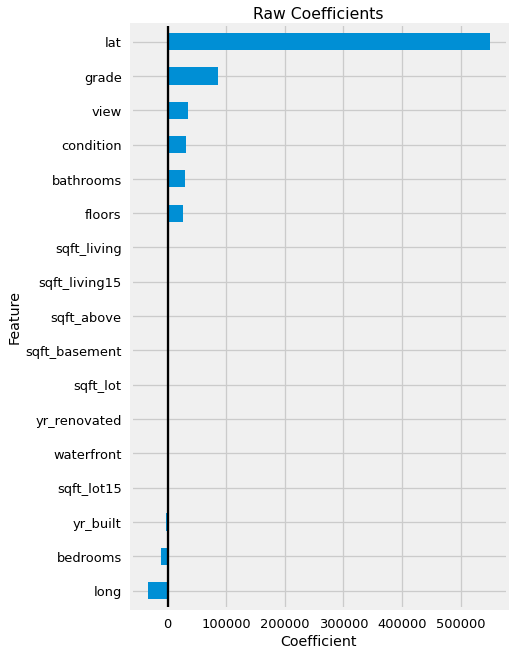

In [45]:
fig_raw =sf.plot_coeffs(result_cln_cnst, ohe_cols, include_const=False,title="Raw Coefficients")

In [46]:
fig_raw_zips =sf.plot_coeffs(result_cln_cnst, nonohe_cols, figsize=(6,12),include_const=True,title="Raw Coefficients")

/Users/codingdojo/Documents/GitHub/_CURRICULUM/curriculum-model-insights/stack_functions.py:152: UserWarning: 
[!] There were no coefficients to plot.
  warnings.warn("\n[!] There were no coefficients to plot.")


### Scaled Numeric - No Constant

In [47]:
X_train_scaled_df_cln.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
count,1.402600e+04,1.402600e+04,1.402600e+04,1.402600e+04,1.402600e+04,14026.0,1.402600e+04,1.402600e+04,1.402600e+04,1.402600e+04,1.402600e+04,1.402600e+04,14026.0,1.402600e+04,1.402600e+04,1.402600e+04,1.402600e+04
mean,2.269522e-16,1.904777e-16,-1.043575e-16,-2.064353e-17,-7.193574e-17,0.0,2.127677e-17,-6.028418e-17,9.574546e-17,1.104366e-16,8.004118e-17,-3.185436e-15,0.0,2.031273e-14,-2.339431e-14,2.836902e-17,2.380972e-17
std,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,0.0,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,0.0,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00
min,-2.737005e+00,-2.222884e+00,-2.137715e+00,-8.144297e-01,-8.951943e-01,0.0,-2.260599e-01,-2.192729e+00,-2.465132e+00,-1.867119e+00,-6.561916e-01,-2.473983e+00,0.0,-2.741890e+00,-2.188505e+00,-2.419371e+00,-9.527262e-01
25%,-3.803916e-01,-7.775766e-01,-7.457843e-01,-4.220039e-01,-8.951943e-01,0.0,-2.260599e-01,-6.515005e-01,-5.203143e-01,-7.421956e-01,-6.561916e-01,-6.459327e-01,0.0,-6.582541e-01,-8.440149e-01,-7.377196e-01,-4.587032e-01
50%,-3.803916e-01,-5.492292e-02,-1.511730e-01,-2.139657e-01,-8.951943e-01,0.0,-2.260599e-01,-6.515005e-01,-5.203143e-01,-2.648063e-01,-6.561916e-01,1.128806e-01,0.0,8.054811e-02,-1.134825e-01,-1.882691e-01,-1.811282e-01
75%,7.979150e-01,6.677308e-01,6.191189e-01,7.211733e-03,9.620640e-01,0.0,-2.260599e-01,8.897284e-01,4.520945e-01,5.655277e-01,6.352936e-01,8.716940e-01,0.0,8.607518e-01,6.714512e-01,5.776316e-01,6.491574e-02
max,3.154528e+00,3.197019e+00,3.781370e+00,1.115929e+01,2.819322e+00,0.0,4.830905e+00,2.430957e+00,3.369321e+00,3.616882e+00,3.502391e+00,1.492541e+00,0.0,1.549587e+00,3.290488e+00,3.541334e+00,9.603089e+00


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.127
Model:                            OLS   Adj. R-squared (uncentered):              0.126
Method:                 Least Squares   F-statistic:                              145.1
Date:                Wed, 22 Jun 2022   Prob (F-statistic):                        0.00
Time:                        21:33:03   Log-Likelihood:                     -2.0396e+05
No. Observations:               14026   AIC:                                  4.079e+05
Df Residuals:                   14012   BIC:                                  4.080e+05
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
bedrooms      -1.036e+04   5527.942     -1.875      0.061   -2.12e+04     471.241
bathrooms      2.032e+04   7483.908      2.716      0.007    5653.728     3.5e+04
sqft_living    3.825e+04   4940.324      7.743      0.000    2.86e+04    4.79e+04
sqft_lot       4953.6367   7249.477      0.683      0.494   -9256.305    1.92e+04
floors         1.388e+04   6222.567      2.230      0.026    1681.839    2.61e+04
waterfront     2.762e-11   4.36e-12      6.332      0.000    1.91e-11    3.62e-11
view           1.372e+04   4365.087      3.144      0.002    5168.297    2.23e+04
condition      2.023e+04   4733.964      4.273      0.000     1.1e+04    2.95e+04
grade          8.918e+04   7204.500     12.379      0.000    7.51e+04    1.03e+05
sqft_above     3.207e+04   4952.552      6.476      0.000    2.24e+04    4.18e+04
sqft_basement   1.42e+04   4671.663      3.040      0.002    5046.362    2.34e+04
yr_built      -6.104e+04   6714.078     -9.091      0.000   -7.42e+04   -4.79e+04
yr_renovated   2.379e-12   1.01e-12      2.357      0.018    4.01e-13    4.36e-12
lat            7.699e+04   4470.059     17.224      0.000    6.82e+04    8.58e+04
long          -4349.7362   5357.235     -0.812      0.417   -1.49e+04    6151.159
sqft_living15  2.813e+04   7263.545      3.872      0.000    1.39e+04    4.24e+04
sqft_lot15    -1.498e+04   7372.097     -2.032      0.042   -2.94e+04    -532.616
==============================================================================
Omnibus:                     4048.868   Durbin-Watson:                   0.139
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18743.461
Skew:                           1.335   Prob(JB):                         0.00
Kurtosis:                       7.994   Cond. No.                     1.70e+18
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 2.5e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

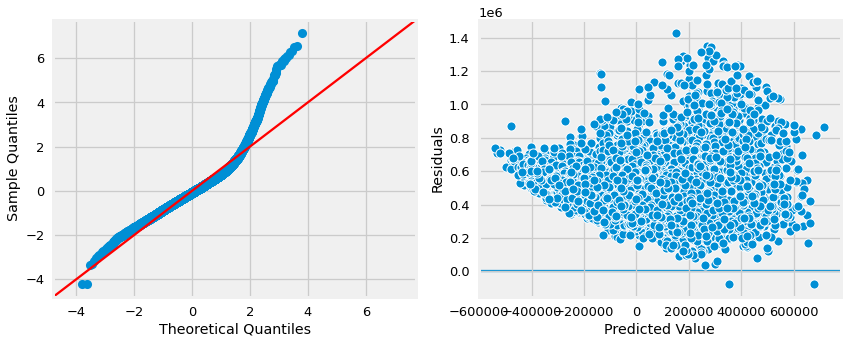

In [48]:
## instantiate an OLS model WITH the training data.
model_cln_scaled = sm.OLS(y_train_cln, X_train_scaled_df_cln)

## Fit the model and view the summary
result_cln_scaled = model_cln_scaled.fit()
sf.evaluate_ols(result_cln_scaled,X_train_scaled_df_cln, y_train_cln)

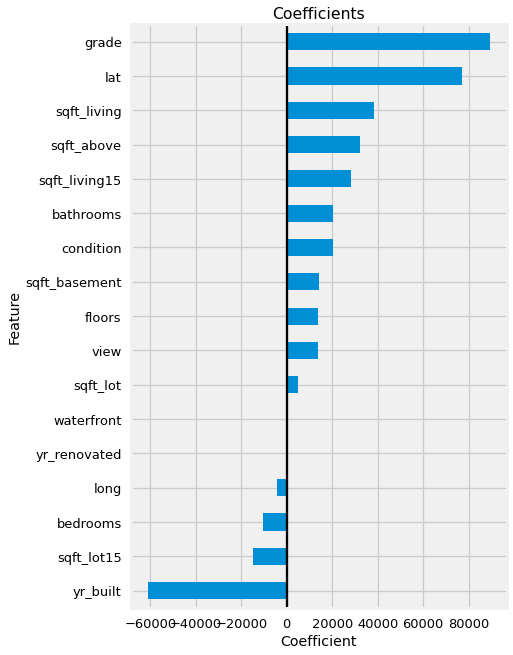

In [49]:
fig_scaled =sf.plot_coeffs(result_cln_scaled,ohe_cols,include_const=True)

In [50]:
fig_scaled_zips =sf.plot_coeffs(result_cln_scaled, nonohe_cols, figsize=(6,12),include_const=True,title="Raw Coefficients")

/Users/codingdojo/Documents/GitHub/_CURRICULUM/curriculum-model-insights/stack_functions.py:152: UserWarning: 
[!] There were no coefficients to plot.
  warnings.warn("\n[!] There were no coefficients to plot.")


### Scaled Numeric - with Constant

In [51]:
X_train_scaled_df_cln_cnst.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,const
count,1.402600e+04,1.402600e+04,1.402600e+04,1.402600e+04,1.402600e+04,14026.0,1.402600e+04,1.402600e+04,1.402600e+04,1.402600e+04,1.402600e+04,1.402600e+04,14026.0,1.402600e+04,1.402600e+04,1.402600e+04,1.402600e+04,14026.0
mean,2.269522e-16,1.904777e-16,-1.043575e-16,-2.064353e-17,-7.193574e-17,0.0,2.127677e-17,-6.028418e-17,9.574546e-17,1.104366e-16,8.004118e-17,-3.185436e-15,0.0,2.031273e-14,-2.339431e-14,2.836902e-17,2.380972e-17,1.0
std,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,0.0,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,0.0,1.000036e+00,1.000036e+00,1.000036e+00,1.000036e+00,0.0
min,-2.737005e+00,-2.222884e+00,-2.137715e+00,-8.144297e-01,-8.951943e-01,0.0,-2.260599e-01,-2.192729e+00,-2.465132e+00,-1.867119e+00,-6.561916e-01,-2.473983e+00,0.0,-2.741890e+00,-2.188505e+00,-2.419371e+00,-9.527262e-01,1.0
25%,-3.803916e-01,-7.775766e-01,-7.457843e-01,-4.220039e-01,-8.951943e-01,0.0,-2.260599e-01,-6.515005e-01,-5.203143e-01,-7.421956e-01,-6.561916e-01,-6.459327e-01,0.0,-6.582541e-01,-8.440149e-01,-7.377196e-01,-4.587032e-01,1.0
50%,-3.803916e-01,-5.492292e-02,-1.511730e-01,-2.139657e-01,-8.951943e-01,0.0,-2.260599e-01,-6.515005e-01,-5.203143e-01,-2.648063e-01,-6.561916e-01,1.128806e-01,0.0,8.054811e-02,-1.134825e-01,-1.882691e-01,-1.811282e-01,1.0
75%,7.979150e-01,6.677308e-01,6.191189e-01,7.211733e-03,9.620640e-01,0.0,-2.260599e-01,8.897284e-01,4.520945e-01,5.655277e-01,6.352936e-01,8.716940e-01,0.0,8.607518e-01,6.714512e-01,5.776316e-01,6.491574e-02,1.0
max,3.154528e+00,3.197019e+00,3.781370e+00,1.115929e+01,2.819322e+00,0.0,4.830905e+00,2.430957e+00,3.369321e+00,3.616882e+00,3.502391e+00,1.492541e+00,0.0,1.549587e+00,3.290488e+00,3.541334e+00,9.603089e+00,1.0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     2065.
Date:                Wed, 22 Jun 2022   Prob (F-statistic):               0.00
Time:                        21:33:04   Log-Likelihood:            -1.8533e+05
No. Observations:               14026   AIC:                         3.707e+05
Df Residuals:                   14011   BIC:                         3.708e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
bedrooms      -1.036e+04   1465.334     -7.073      0.000   -1.32e+04   -7492.012
bathrooms      2.032e+04   1983.817     10.244      0.000    1.64e+04    2.42e+04
sqft_living    3.825e+04   1309.570     29.210      0.000    3.57e+04    4.08e+04
sqft_lot       4953.6367   1921.675      2.578      0.010    1186.898    8720.375
floors         1.388e+04   1649.464      8.414      0.000    1.06e+04    1.71e+04
waterfront    -3.077e-11   7.98e-13    -38.539      0.000   -3.23e-11   -2.92e-11
view           1.372e+04   1157.087     11.861      0.000    1.15e+04     1.6e+04
condition      2.023e+04   1254.868     16.122      0.000    1.78e+04    2.27e+04
grade          8.918e+04   1909.752     46.699      0.000    8.54e+04    9.29e+04
sqft_above     3.207e+04   1312.811     24.429      0.000    2.95e+04    3.46e+04
sqft_basement   1.42e+04   1238.354     11.470      0.000    1.18e+04    1.66e+04
yr_built      -6.104e+04   1779.752    -34.296      0.000   -6.45e+04   -5.75e+04
yr_renovated  -1.577e-12   1.03e-13    -15.256      0.000   -1.78e-12   -1.37e-12
lat            7.699e+04   1184.913     64.977      0.000    7.47e+04    7.93e+04
long          -4349.7362   1420.084     -3.063      0.002   -7133.289   -1566.183
sqft_living15  2.813e+04   1925.404     14.608      0.000    2.44e+04    3.19e+04
sqft_lot15    -1.498e+04   1954.178     -7.667      0.000   -1.88e+04   -1.12e+04
const          4.821e+05   1119.741    430.583      0.000     4.8e+05    4.84e+05
==============================================================================
Omnibus:                     4048.868   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18743.461
Skew:                           1.335   Prob(JB):                         0.00
Kurtosis:                       7.994   Cond. No.                     5.80e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.14e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

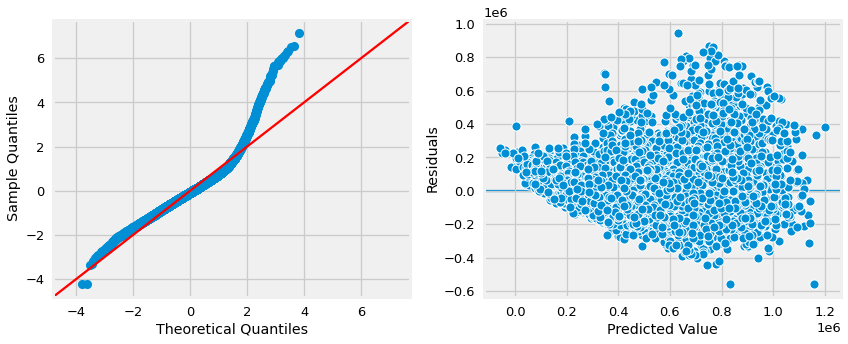

In [52]:
## instantiate an OLS model WITH the training data.
model_cln_scaled_cnst = sm.OLS(y_train_cln, X_train_scaled_df_cln_cnst)

## Fit the model and view the summary
result_cln_scaled_cnst = model_cln_scaled_cnst.fit()
sf.evaluate_ols(result_cln_scaled_cnst,X_train_scaled_df_cln_cnst, y_train_cln)

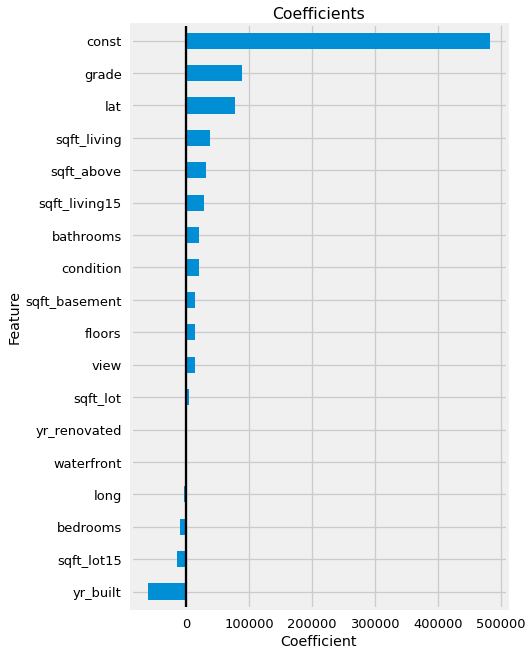

In [53]:
fig_scaled =sf.plot_coeffs(result_cln_scaled_cnst,ohe_cols,include_const=True)

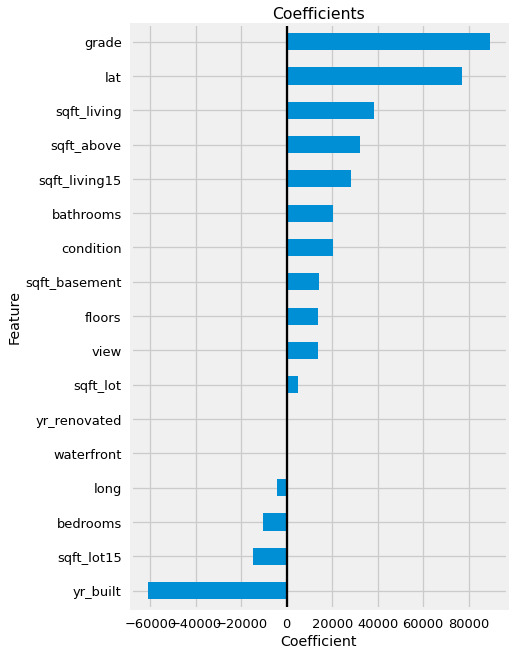

In [54]:
fig_scaled =sf.plot_coeffs(result_cln_scaled_cnst,ohe_cols,include_const=False)

# Adding Explanations

## Sklearn LinearRegression

> Pick 1 of the statsmodels models above to remake in sklearn for model explanations

In [55]:
from sklearn.linear_model import LinearRegression

In [56]:
## Making new var name sfor sklearn - update these to change model
ols_results = result_scaled_cnst
# sf.evaluate_ols(ols_results,X_tr,y_tr)
X_tr = X_train_scaled_df_cnst
X_te = X_test_scaled_df_cnst
y_tr = y_train
y_te = y_test

## If const in orig df, 
fit_intercept = 'const' in X_tr.columns

if fit_intercept==True:
    X_tr = X_tr.drop(columns='const')
    X_te = X_te.drop(columns='const')
fit_intercept

True

In [57]:
linreg = LinearRegression(fit_intercept=fit_intercept)
linreg.fit(X_tr, y_tr)
print(f"Train R^2: {format(linreg.score(X_tr,y_tr),'.2f')}")
print(f"Test R^2: {format(linreg.score(X_te,y_te),'.2f')}")
linreg.get_params()

Train R^2: 0.70
Test R^2: 0.69


{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': 'deprecated',
 'positive': False}

In [58]:
coeffs = sf.get_coeffs(linreg,X_tr,name='LinReg Coeffs')
coeffs#.head(20)

bedrooms        -2.924000e+04
bathrooms        3.303960e+04
sqft_living     -5.312301e+17
sqft_lot         4.658496e+03
floors          -9.316219e+02
waterfront       5.191409e+04
view             4.080079e+04
condition        1.971326e+04
grade            1.179507e+05
sqft_above       4.806650e+17
sqft_basement    2.551307e+17
yr_built        -7.004823e+04
yr_renovated     8.116486e+03
lat              7.860327e+04
long            -1.783783e+04
sqft_living15    1.877693e+04
sqft_lot15      -9.318026e+03
const            5.417460e+05
Name: LinReg Coeffs, dtype: float64

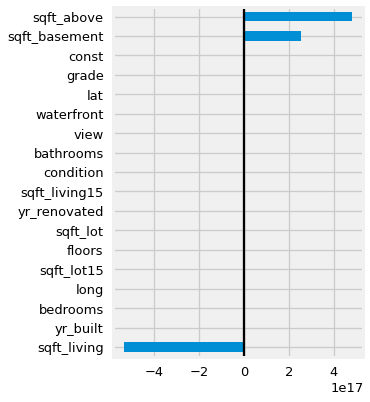

In [59]:
ax = coeffs.drop(ohe_cols).sort_values().plot(kind='barh',figsize=(4,6))
ax.axvline(0,color='black')

In [60]:
if len(ohe_cols)>1:

    ax = coeffs[ohe_cols].sort_values().plot(kind='barh',figsize=(4,6))
    ax.axvline(0,color='black')

In [61]:
## save 1 df of skelarn vs ols coeffs
compare_coeffs = pd.DataFrame({'OLS':ols_results.params,
                              'LinReg':coeffs}).round(2)
compare_coeffs['Agree?'] = compare_coeffs['OLS']==compare_coeffs['LinReg']

display(compare_coeffs.round(3))
compare_coeffs['Agree?'].value_counts(1)
#compare_coeffs.style.format({'OLS':"{:,.2f}","LinReg":"{:,.2f}"})

,OLS,LinReg,Agree?
bedrooms,-29680.30,-2.924000e+04,False
bathrooms,33379.19,3.303960e+04,False
sqft_living,78010.29,-5.312301e+17,False
sqft_lot,4534.83,4.658500e+03,False
floors,-1173.17,-9.316200e+02,False
waterfront,51980.37,5.191409e+04,False
view,40868.99,4.080079e+04,False
condition,19588.83,1.971326e+04,False
grade,118040.72,1.179507e+05,False
sqft_above,73312.43,4.806650e+17,False


False    1.0
Name: Agree?, dtype: float64

In [62]:
compare_coeffs[compare_coeffs['Agree?']==True]

,OLS,LinReg,Agree?


In [63]:
# compare_coeffs[compare_coeffs['Agree?']==False]

In [64]:
compare_coeffs.style.bar()

,OLS,LinReg,Agree?
bedrooms,-29680.300000,-29240.000000,False
bathrooms,33379.190000,33039.600000,False
sqft_living,78010.290000,-531230129147612544.000000,False
sqft_lot,4534.830000,4658.500000,False
floors,-1173.170000,-931.620000,False
waterfront,51980.370000,51914.090000,False
view,40868.990000,40800.790000,False
condition,19588.830000,19713.260000,False
grade,118040.720000,117950.720000,False
sqft_above,73312.430000,480665035137754176.000000,False


> ISSUE WITH COEFFICIENTS NOT MATCHING - SEE IF TRUE FOR OTHER DATASETS. 

### Shap

In [65]:
import shap
shap.initjs()

shap.__version__

'0.41.0'

In [66]:
## sampling 200 rows from training data
X_shap = shap.sample(X_tr,nsamples=200,random_state=321)

In [67]:
## Creating explainer from model and getting shap values
explainer = shap.LinearExplainer(linreg,X_shap)
shap_values = explainer(X_shap)
shap_values.shape

(200, 17)

In [68]:
# [i for i in dir(shap_values) if not i.startswith("_")]

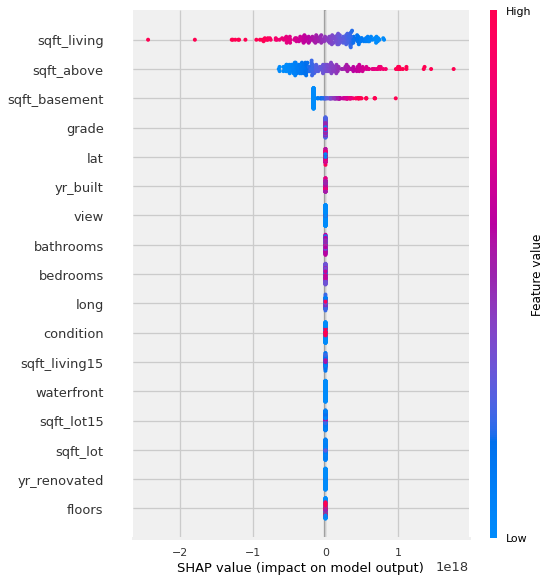

In [69]:
shap.summary_plot(shap_values)

In [70]:
explainer.expected_value

517752.7052762051

In [71]:
shap.force_plot(explainer.expected_value,shap_values= shap_values.values, features=X_shap)       

## RandomForest

In [72]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor()
rf_reg.fit(X_tr,y_tr)

RandomForestRegressor()

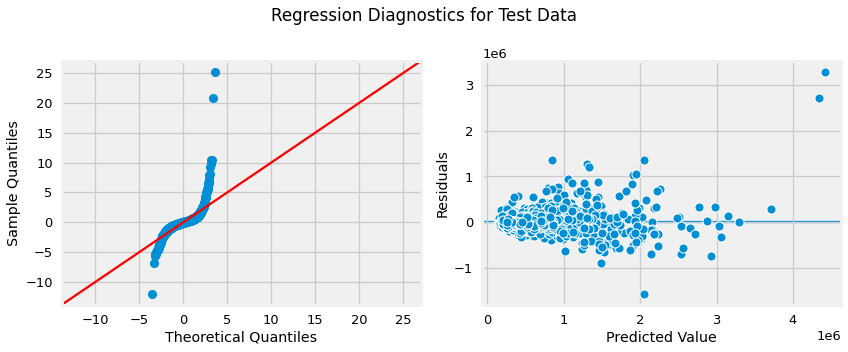

Score
Metric Split           
R^2    Train       0.98
       Test        0.87
RMSE   Train   49020.12
       Test   130679.44

In [73]:
scores = sf.evaluate_regression(rf_reg,X_te, y_te, X_train_df=X_tr, y_train=y_tr,
                            return_scores=True)

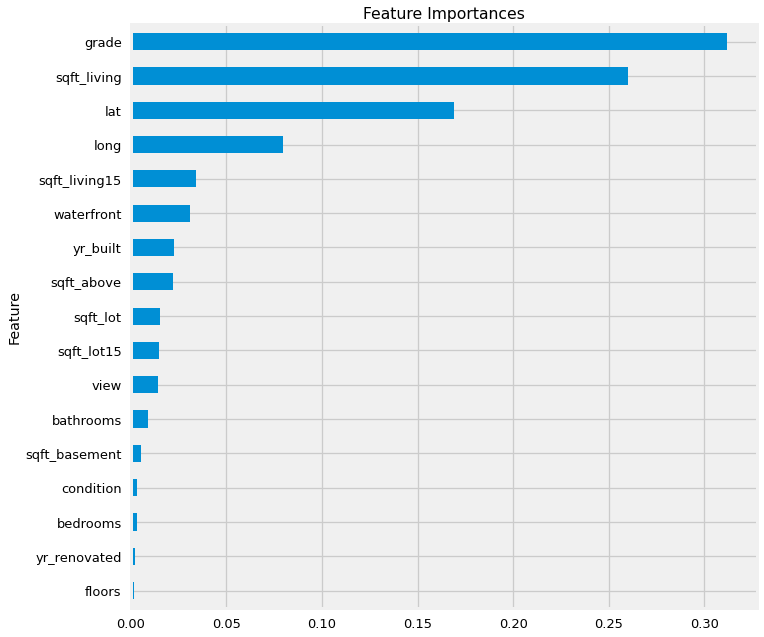

In [74]:
importances = sf.get_importance(rf_reg,X_test_df,top_n=50)

### Permutation Importance

In [75]:
from sklearn.inspection import permutation_importance
## Permutation importance takes a fit mode and test data. 
r = permutation_importance(linreg, X_tr, y_tr,
#                            n_repeats=30
                          )
r.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [76]:
## can make the mean importances into a series
permutation_importances = pd.Series(r['importances_mean'],index=X_tr.columns,
                           name = 'permutation importance')
permutation_importances

bedrooms         1.349449e-02
bathrooms        1.557588e-02
sqft_living      4.179408e+24
sqft_lot         3.110655e-04
floors           1.898653e-05
waterfront       4.136385e-02
view             2.467887e-02
condition        5.515713e-03
grade            2.053104e-01
sqft_above       3.415651e+24
sqft_basement    9.542799e+23
yr_built         7.350544e-02
yr_renovated     9.413882e-04
lat              9.257293e-02
long             4.991125e-03
sqft_living15    5.068415e-03
sqft_lot15       1.364532e-03
Name: permutation importance, dtype: float64

<AxesSubplot:>

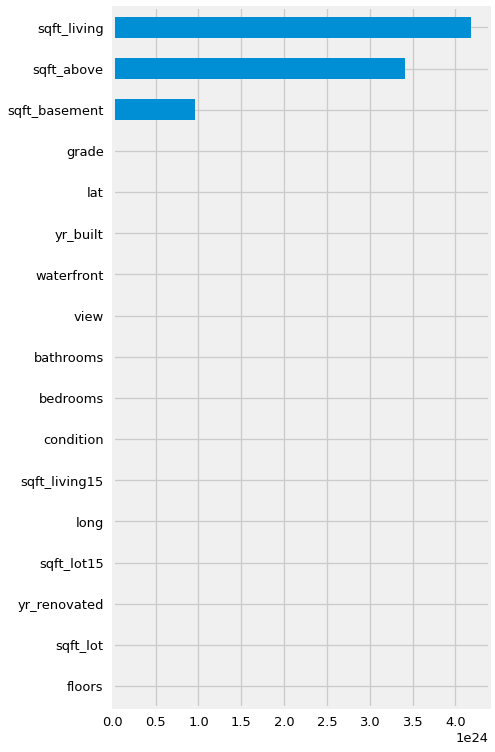

In [77]:
permutation_importances.sort_values().tail(20).plot(kind='barh',figsize=(6,12))

In [78]:
X_shap = shap.sample(X_tr,nsamples=200,random_state=321)

In [79]:
explainer = shap.TreeExplainer(rf_reg,X_shap)
shap_values = explainer(X_shap)

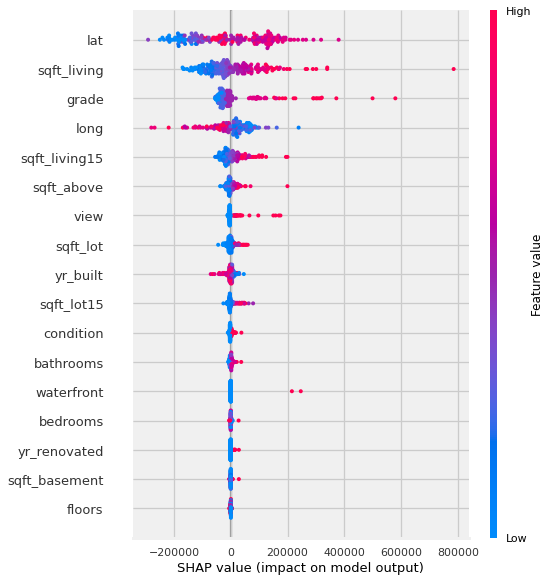

In [80]:
shap.summary_plot(shap_values)

In [81]:
shap.force_plot(explainer.expected_value,shap_values= shap_values.values, features=X_shap)       

# Post-Hoc EDA

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

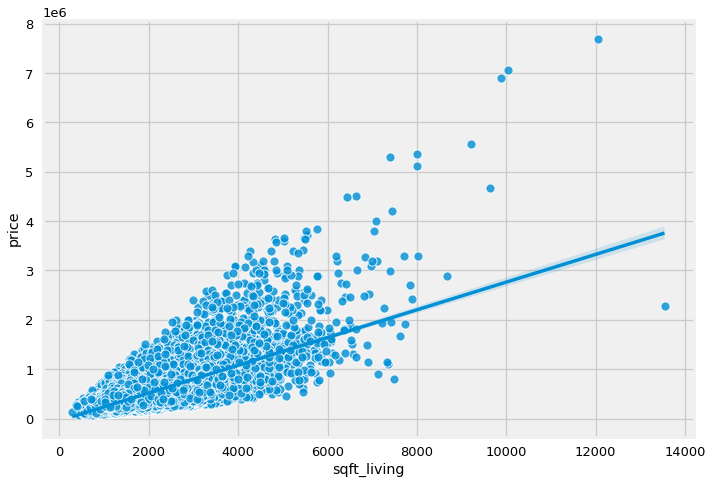

In [83]:
sns.regplot(data=df, x='sqft_living',y='price', scatter_kws={'ec':'white','lw':1})

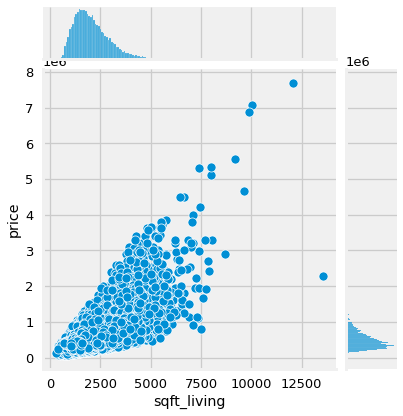

In [89]:
sns.jointplot(data=df, x='sqft_living',y='price')#, scatter_kws={'ec':'white','lw':1})

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

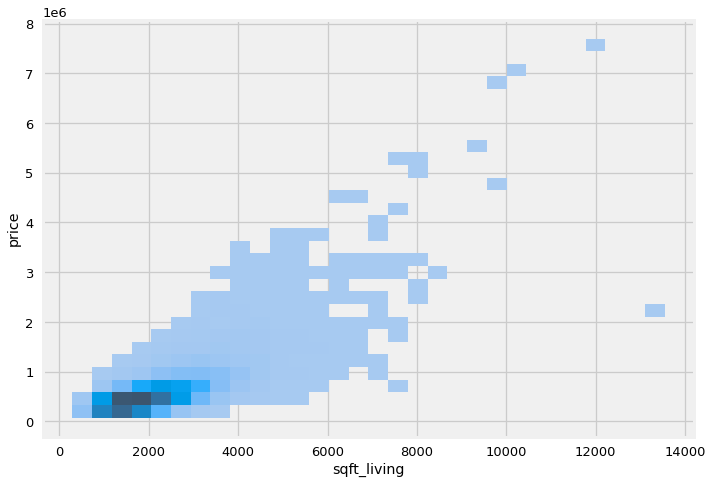

In [92]:
sns.histplot(data=df, x='sqft_living',y="price",bins=30)